In [1]:
## We need to load Grid World env stored in lib copy it on google drive or upload it on colab

# from google.colab import drive
# drive.mount('/content/drive')

# !cp -a drive/My\ Drive/Colab\ Notebooks/RL_Notebooks/lib /content/

Mounted at /content/drive


In [0]:
import numpy as np
import random
import copy
import sys
from lib.envs.gridworld import GridworldEnv

### GridWorld Environment

![Grid World](images/grid_world.png)


In this environment, we are given 2 terminal states and 1 starting state. 

An agent can take 4 actions when in any state(up=0, right=1, down=2, left=3).


In [0]:
env = GridworldEnv()

In [5]:
env._render()

T  o  o  x
o  o  o  o
o  o  o  o
o  o  o  T


In [0]:
action = ["up", "right", "down", "left"]

In [7]:
# 4x4 grid = 16 states
print ("Number of states:", env.nS)
# either go left, up, down or right
print ("Number of actions that an agent can take:", env.nA)

Number of states: 16
Number of actions that an agent can take: 4


In [8]:
# Where am I?
print ("Current state", env.s)
# What are my options?
print ("Transitions from current state:", env.P[env.s])

Current state 3
Transitions from current state: {0: [(1.0, 3, -1.0, False)], 1: [(1.0, 3, -1.0, False)], 2: [(1.0, 7, -1.0, False)], 3: [(1.0, 2, -1.0, False)]}


In [9]:
# Taking a step by selecting a random action[up=0, right=1, down=2, left=3] from current state
# next state: Where do I end up?
# reward: What rewards did I recieve?
# is_terminal: did I end up in the goal state?
# t_prob: What is probability of ending up in next state taking that action?
rnd_action = random.randint(0, 3)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal, t_prob = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)
env._render()

Action taken: left
Transition probability: {'prob': 1.0}
Next state: 2
Reward recieved: -1.0
Terminal state: False
T  o  x  o
o  o  o  o
o  o  o  o
o  o  o  T


### Policy Evaluation

The goal in policy evaluation is to evaluate any given valid policy. Policy will be a matrix of shape (S, A) which provides mapping from states to action.

$$
\begin{aligned} 
v_{k+1}(s) &= \sum_{a \in \mathcal{A}}\pi(a \vert s)[\mathcal{R}_{s}^{a} + \gamma \sum_{s^{'} \in S}\mathcal{P}_{ss^{'}}^{a}v{k}(s^{'})]
\end{aligned} 
$$

![Policy Evaluation](images/pe.png)


In [0]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: env.P represents the transition probabilities of the environment.
             env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
             env.nS is a number of states in the environment. 
             env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    values = list()
    values.append(np.copy(V))
    
    while True:
        delta = 0
        # for each state s in the environment
        for s in range(env.nS):
            
            # what actions can be taken when in state s according to policy
            A = policy[s]
            v_s = 0
            
            # for each action a that can be taken when in state s under policy with probability action_prob
            for a, action_prob in enumerate(A):
            
               # expected returns from all states that can be visited taking action a
               for (t_prob, next_state, reward, is_terminal) in env.P[s][a]:
                   # probability of taking action a * probability of ending in next state *
                   # [immediate reward + discount * returns from next state]
                   v_s += action_prob * t_prob * (reward + discount_factor * V[next_state])
            
            delta = max(delta, abs(v_s-V[s]))
            V[s] = v_s
        
        values.append(np.copy(V))
        
        # values of all states is less than theta
        if (delta < theta):
            break
    return V, values

In [0]:
# equiprobable random policy
random_policy = np.ones([env.nS, env.nA]) / env.nA

In [29]:
%%time
v, val = policy_eval(random_policy, env)

CPU times: user 16.9 ms, sys: 0 ns, total: 16.9 ms
Wall time: 17 ms


In [30]:
print("Value Function:")
print(v)
print("")

Value Function:
[  0.         -13.99993529 -19.99990698 -21.99989761 -13.99993529
 -17.9999206  -19.99991379 -19.99991477 -19.99990698 -19.99991379
 -17.99992725 -13.99994569 -21.99989761 -19.99991477 -13.99994569
   0.        ]



In [31]:
print (len(val))

142


In [0]:
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
%matplotlib inline

def show_anim(val, name='value_function', n=4):

    def barlist(n):
        return val[n]

    fig=plt.figure()
    x=range(16)
    ylim = [-25, 0]
    barcollection = plt.bar(x, barlist(0))
    plt.ylim(ylim)

    def animate(i):
        y = barlist(i+1)
        plt.cla()
        bar = plt.gca().bar(x, barlist(i))
        plt.ylim(ylim)

    anim=animation.FuncAnimation(fig,animate, blit=False, repeat=False, frames=n)

    anim.save(name+'.mp4', writer=animation.FFMpegWriter(fps=1))

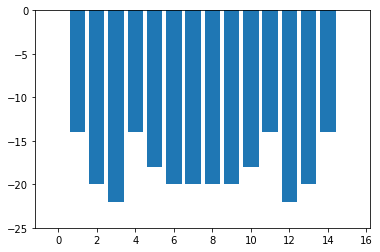

In [36]:
show_anim(val, 'value_function', n=141)

In [0]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('value_function.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [0]:
# Test: Make sure the evaluated policy is what we expected
expected_v = np.array([0, -14, -20, -22, -14, -18, -20, -20, -20, -20, -18, -14, -22, -20, -14, 0])
np.testing.assert_array_almost_equal(v, expected_v, decimal=2)

### Policy Iteration

The goal in policy iteration is to find optimal policy.

Policy iteration consits of 2 steps. Given a policy, we evaluate given policy using policy evaluation from above and we act greedy with respect to value function obtained in policy evaluation step to get a improved policy. This step is called policy improvement step. We repeat these 2 steps until policy converges i.e there is no change in old and new improved policy.


![Policy Iteration](images/pi.png)

In [0]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: env.P represents the transition probabilities of the environment.
             env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
             env.nS is a number of states in the environment. 
             env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    values = list()
    values.append(np.copy(V))
    
    while True:
        delta = 0
        # for each state s in the environment
        for s in range(env.nS):        
            # what actions can be taken when in state s according to policy
            A = policy[s]
            v_s = 0  
            # for each action a that can be taken when in state s under policy with probability action_prob
            for a, action_prob in enumerate(A):
               # expected returns from all states that can be visited taking action a
               for (t_prob, next_state, reward, is_terminal) in env.P[s][a]:
                   # probability of taking action a * probability of ending in next state *
                   # [immediate reward + discount * returns from next state]
                   v_s += action_prob * t_prob * (reward + discount_factor * V[next_state])      
            delta = max(delta, abs(v_s-V[s]))
            V[s] = v_s     
        values.append(np.copy(V))    
        # values of all states is less than theta
        if (delta < theta):
            break
    return V, values

In [0]:
def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    # Start with a equiprobable policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    val = list()
    pol = list()
    while True:
        # evaluate the given policy
        V, _ = policy_eval_fn(policy, env, discount_factor)
        val.append(np.copy(V))
        # improve the policy by being greedy wrt to current value function
        policy_stable = True
        old_policy = policy.copy()
        pol.append(np.copy(old_policy))
        for s in range(env.nS):
            v = []      
            # find returns for each action a
            for a in range(env.nA):   
                # expected returns from all states that can be visited taking action a
                v_s = 0
                for (t_prob, next_state, reward, is_terminal) in env.P[s][a]:
                    # probability of taking action a * probability of ending in next state *
                    # [immediate reward + discount * returns from next state]
                    v_s += t_prob * (reward + discount_factor * V[next_state])
                v.append(v_s)
            policy[s] = np.eye(env.nA)[np.argmax(v)]
            if (np.argmax(v) != np.argmax(old_policy[s])):
                policy_stable = False
        # if policy no longer improves, we found optimal policy
        if (policy_stable):
            return (policy, V, val, pol)

In [41]:
%%time
policy, v, val, pol = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

CPU times: user 20.5 ms, sys: 0 ns, total: 20.5 ms
Wall time: 21.6 ms


In [42]:
print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
actions = np.stack([action for _ in range(len(policy))], axis=0)
print (np.reshape(np.argmax(policy, axis=1), env.shape))
print ("")

print ("Optimal Policy:")
print(np.take(actions, np.reshape(np.argmax(policy, axis=1), env.shape)))
print("")

print("Optimal Value Function:")
print(v)
print("")

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]

Optimal Policy:
[['up' 'left' 'left' 'down']
 ['up' 'up' 'up' 'down']
 ['up' 'up' 'right' 'down']
 ['up' 'right' 'right' 'up']]

Optimal Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]



In [43]:
print (len(val), len(pol))

3 3


In [0]:
val

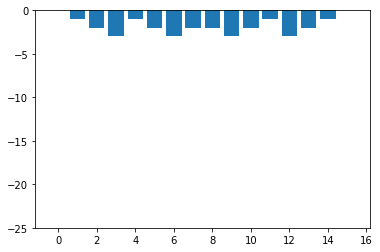

In [45]:
show_anim(val, 'pi_value_function', n=2)

In [50]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('pi_value_function.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

### Generalized Policy Iteration (GPI)

The goal in gpi is to find optimal policy and optimal value function.  

In generalized policy iteration, we perform continuous iterations of each policy evaluation and policy iteration alternatively. The value function is altered to more closely approximate the value function for the current policy, and the policy is repeatedly improved with respect to the current value function. Eventually both approximate value function and policy converges to optimal value function and optimal policy.

![GPI](images/policy_iteration_0.png)
![GPI_1](images/policy_iteration.png)

In [0]:
def policy_eval(policy, env, V, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: env.P represents the transition probabilities of the environment.
             env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
             env.nS is a number of states in the environment. 
             env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    values = list()
    values.append(np.copy(V))
    
    # for each state s in the environment
    for s in range(env.nS):        
        # what actions can be taken when in state s according to policy
        A = policy[s]
        v_s = 0  
        # for each action a that can be taken when in state s under policy with probability action_prob
        for a, action_prob in enumerate(A):
            # expected returns from all states that can be visited taking action a
            for (t_prob, next_state, reward, is_terminal) in env.P[s][a]:
                # probability of taking action a * probability of ending in next state *
                # [immediate reward + discount * returns from next state]
                v_s += action_prob * t_prob * (reward + discount_factor * V[next_state])
        V[s] = v_s     
    values.append(np.copy(V))
    return V, values

In [0]:
def policy_improvement(env, policy, V, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    # improve the policy by being greedy wrt to current value function
    old_policy = policy.copy()
    for s in range(env.nS):
        v = []      
        # find returns for each action a
        for a in range(env.nA):   
            # expected returns from all states that can be visited taking action a
            v_s = 0
            for (t_prob, next_state, reward, is_terminal) in env.P[s][a]:
                # probability of taking action a * probability of ending in next state *
                # [immediate reward + discount * returns from next state]
                v_s += t_prob * (reward + discount_factor * V[next_state])
            v.append(v_s)
        policy[s] = np.eye(env.nA)[np.argmax(v)]
    return policy

In [0]:
def gpi(env, policy, V, policy_eval_fn=policy_eval, policy_improve_fn=policy_improvement, discount_factor=1.0, theta=0.00001):
    
    count = 0
    val = list()
    pol = list()
    while True:
        V, _ = policy_eval_fn(policy, env, V, discount_factor, theta)
        val.append(np.copy(V))
        old_policy = policy.copy()
        pol.append(np.copy(old_policy))
        policy = policy_improve_fn(env, policy, V, discount_factor)
        count += 1
        if (np.array_equal(old_policy, policy)):
            break

    print ("Number of iterations for optimal policy to converge:", count)

    return policy, V, val, pol

In [55]:
%%time
# Start with a equiprobable policy
policy = np.ones([env.nS, env.nA]) / env.nA

# Start with a random (all 0) value function
V = np.zeros(env.nS)

policy, v, val, pol = gpi(env, policy, V)
print("Policy Probability Distribution:")
print(policy)
print("")

Number of iterations for optimal policy to converge: 4
Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

CPU times: user 5.66 ms, sys: 0 ns, total: 5.66 ms
Wall time: 5.69 ms


In [56]:
print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
actions = np.stack([action for _ in range(len(policy))], axis=0)
print (np.reshape(np.argmax(policy, axis=1), env.shape))
print ("")

print ("Optimal Policy:")
print(np.take(actions, np.reshape(np.argmax(policy, axis=1), env.shape)))
print("")

print("Optimal Value Function:")
print(v)
print("")

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]

Optimal Policy:
[['up' 'left' 'left' 'down']
 ['up' 'up' 'up' 'down']
 ['up' 'up' 'right' 'down']
 ['up' 'right' 'right' 'up']]

Optimal Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]



In [57]:
print (len(val), len(pol))

4 4


In [63]:
val

[array([ 0.       , -1.       , -1.25     , -1.3125   , -1.       ,
        -1.5      , -1.6875   , -1.75     , -1.25     , -1.6875   ,
        -1.84375  , -1.8984375, -1.3125   , -1.75     , -1.8984375,
         0.       ]),
 array([ 0., -1., -2., -3., -1., -2., -3., -4., -2., -3., -4., -1., -3.,
        -4., -1.,  0.]),
 array([ 0., -1., -2., -3., -1., -2., -3., -2., -2., -3., -2., -1., -3.,
        -2., -1.,  0.]),
 array([ 0., -1., -2., -3., -1., -2., -3., -2., -2., -3., -2., -1., -3.,
        -2., -1.,  0.])]

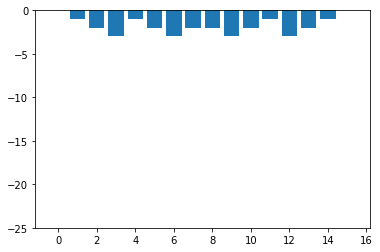

In [61]:
show_anim(val, 'gpi_value_function', n=3)

In [62]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('gpi_value_function.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

### Value Iteration

The goal in value iteration is to find optimal value function.


$$ \begin{aligned} v_{k+1}(s) &= max_{a \in \mathcal{A}}[\mathcal{R}{s}^{a} + \gamma \sum{s^{'} \in S}\mathcal{P}{ss^{'}}^{a}v{k}(s^{'})]\ \end{aligned} $$


![Value Iteration](images/vi.png)

In [0]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    values = list()
    values.append(np.copy(V))
    
    while True:
        delta = 0
        # for each state s in the environment
        for s in range(env.nS):
            v = []
            # for each action a that can be taken when in state s
            for a in range(env.nA):
                # expected returns from all states that can be visited taking action a
                v_s = 0
                for (t_prob, next_state, reward, is_terminal) in env.P[s][a]:
                    # probability of taking action a * probability of ending in next state *
                    # [immediate reward + discount * returns from next state]
                    v_s += t_prob * (reward + discount_factor * V[next_state])
                v.append(v_s)
            delta = max(delta, abs(np.max(v)-V[s]))
            V[s] = np.max(v)
        values.append(np.copy(V))    
        # values of all states is less than theta
        if (delta < theta):
            break
    
        for s in range(env.nS):
            v = []      
            # find returns for each action a
            for a in range(env.nA):   
                # expected returns from all states that can be visited taking action a
                v_s = 0
                for (t_prob, next_state, reward, is_terminal) in env.P[s][a]:
                    # probability of taking action a * probability of ending in next state *
                    # [immediate reward + discount * returns from next state]
                    v_s += t_prob * (reward + discount_factor * V[next_state])
                v.append(v_s)
            policy[s] = np.eye(env.nA)[np.argmax(v)]
    
    return policy, V, values

In [65]:
%%time
policy, v, val = value_iteration(env)

print("Policy Probability Distribution:")
print(policy)
print("")

Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

CPU times: user 3.87 ms, sys: 0 ns, total: 3.87 ms
Wall time: 6.46 ms


In [66]:
print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
actions = np.stack([action for _ in range(len(policy))], axis=0)
print (np.reshape(np.argmax(policy, axis=1), env.shape))
print ("")

print ("Optimal Policy:")
print(np.take(actions, np.reshape(np.argmax(policy, axis=1), env.shape)))
print("")

print("Optimal Value Function:")
print(v)
print("")

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]

Optimal Policy:
[['up' 'left' 'left' 'down']
 ['up' 'up' 'up' 'down']
 ['up' 'up' 'right' 'down']
 ['up' 'right' 'right' 'up']]

Optimal Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]



In [0]:
# Test the value function
expected_v = np.array([ 0, -1, -2, -3, -1, -2, -3, -2, -2, -3, -2, -1, -3, -2, -1,  0])
np.testing.assert_array_almost_equal(v, expected_v, decimal=2)

In [69]:
print (len(val))

5


In [71]:
val

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.,  0.]),
 array([ 0., -1., -2., -2., -1., -2., -2., -2., -2., -2., -2., -1., -2.,
        -2., -1.,  0.]),
 array([ 0., -1., -2., -3., -1., -2., -3., -2., -2., -3., -2., -1., -3.,
        -2., -1.,  0.]),
 array([ 0., -1., -2., -3., -1., -2., -3., -2., -2., -3., -2., -1., -3.,
        -2., -1.,  0.])]

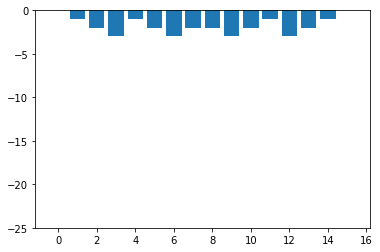

In [70]:
show_anim(val, 'vi_value_function', n=4)

In [72]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('vi_value_function.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)